In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def topo_sort(root):
  visited = set()
  topo = []
  def build_topo(v):
    if v not in visited:
      visited.add(v)
      for child in v._prev:
          build_topo(child)
      topo.append(v)
  build_topo(root)
  return topo


In [ ]:
class Value:
  def __init__(self,data, _children=(),_op='', label=""):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda : None
    self.grad = 0

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),"+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data,(self,other),"*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self,),"tanh")
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = topo_sort(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [ ]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges

def draw_dot(root):
  dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape='record')
    if n._op:
      dot.node(name=uid+n._op,label=n._op)
      dot.edge(uid+n._op,uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot


In [ ]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.8813735870195432, label="b")
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()
o.label = "o"


In [ ]:
o.backward()

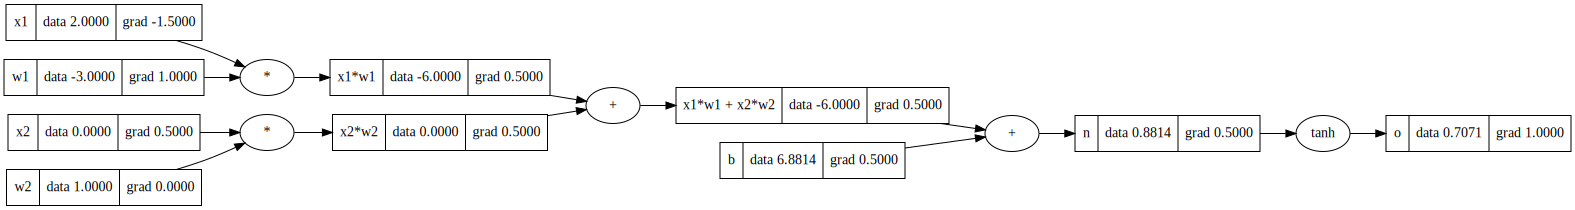

In [ ]:
draw_dot(o)

In [ ]:
from typing import Sized
class Neuron():
  def __init__(self,nin) -> None:
    self.w = [Value(random.uniform(-2,2)) for _ in range(nin)]
    self.b = Value(random.uniform(-2,2))

  def __call__(self, x):
    act = sum(((wi*xi) for wi,xi in list(zip(self.w,x))),self.b)
    out = act.tanh()
    return out

class Layer():
  def __init__(self,nin,nout) -> None:
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP():
  def __init__(self,nin,nouts):
    sz = [nin] + nouts
    print(sz)
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

x = [2.0,3.0]
n = MLP(2,[3,1])
out =n(x)

[2, 3, 1]


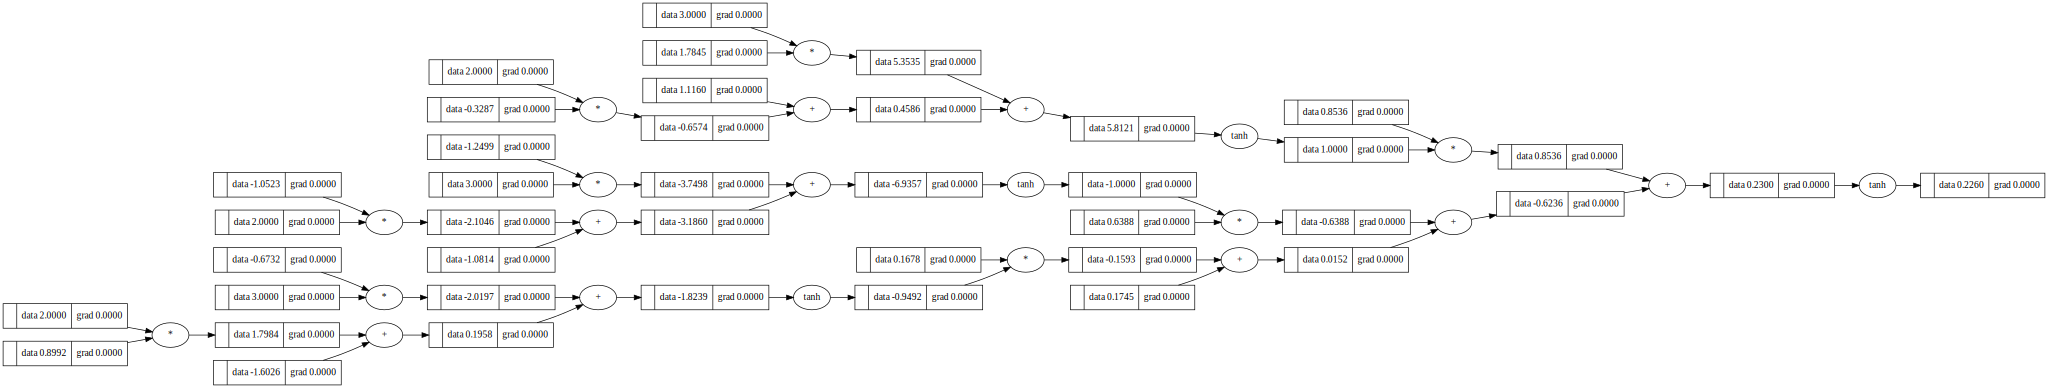

In [ ]:
draw_dot(out)

In [ ]:
xs = [
    [2.0 , 3.0 , -1.0],
    [3.0 , -1.0 , 0.5],
    [0.5 , 1.0 , 1.0],
    [1.0 , 1.0 , -1.0]
]
ys = [1.0, -1.0, -1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.22603612844581084),
 Value(data=-0.7991132557729944),
 Value(data=0.2232150686291596),
 Value(data=0.2290327851095544)]

In [ ]:
loss = [(yout-ygt)**2 for ygt, yout in zip(ys,ypred)]
loss

TypeError: unsupported operand type(s) for -: 'Value' and 'float'